<a href="https://colab.research.google.com/github/Jadhav01351/Major-Project/blob/main/Copy_of_N_DCGAN_(1).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Clone repository and install requirements

In [ ]:
!git clone https://github.com/kad99kev/FGTD.git

Cloning into 'FGTD'...
remote: Enumerating objects: 743, done.
remote: Counting objects: 100% (22/22), done.
remote: Compressing objects: 100% (14/14), done.
remote: Total 743 (delta 21), reused 8 (delta 8), pack-reused 721
Receiving objects: 100% (743/743), 85.16 MiB | 23.41 MiB/s, done.
Resolving deltas: 100% (393/393), done.


In [ ]:
import sys
sys.path.append('/content/FGTD/scripts')

In [ ]:
!pip install -r /content/FGTD/requirements.txt

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 78.9/78.9 kB 3.6 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.1/2.1 MB 15.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.1/7.1 MB 32.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 30.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 184.3/184.3 kB 18.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 206.5/206.5 kB 25.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 97.4/97.4 kB 6.3 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.7/62.7 kB 10.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 224.5/224.5 kB 30.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.8/7.8 MB 

# Import dependencies

In [ ]:
import os

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import random

from sklearn.metrics.pairwise import cosine_similarity
from PIL import Image
from tqdm.notebook import tqdm
from dataclasses import asdict, dataclass

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms

In [ ]:
import torch
import os
import random

import pandas as pd
import numpy as np

from PIL import Image
from tqdm.notebook import tqdm

np.random.seed(0)
torch.manual_seed(0)


class ImageTextDataset(torch.utils.data.Dataset):
    """
    Meant for CelebA Dataset'.
    Pairs True Image, True Text and Wrong Image
    """

    def __init__(self, root_dir, csv_file, transform=None):
        """
        Args:
            root_dir (string): Directory with all the images.
            csv_file (string): Path to the csv file with annotations.
            transform (callable, optional): Optional transform to be applied on a sample.
        """
        self.text_df = pd.read_csv(csv_file)
        self.length = len(self.text_df)
        self.root_dir = root_dir
        self.transform = transform

    def __len__(self):
        return len(self.text_df)

    def __getitem__(self, idx):
        if torch.is_tensor(idx):
            idx = idx.tolist()

        # Real Images
        img_name = os.path.join(self.root_dir, self.text_df.iloc[idx, 0])
        image = Image.open(img_name)

        true_text = self.text_df.iloc[idx, 1:].values[0]

        if self.transform:
            true_image = self.transform(image)

        # Wrong Images
        wrong_idx = random.randint(0, self.length - 1)
        while wrong_idx == idx:
            # To get a different index incase it is same
            wrong_idx = random.randint(0, self.length - 1)
        wrong_img_name = os.path.join(self.root_dir, self.text_df.iloc[wrong_idx, 0])
        wrong_image = Image.open(wrong_img_name)

        if self.transform:
            wrong_image = self.transform(wrong_image)

        return true_image, true_text, wrong_image


def process_data(attribute_csv_path):
    """
    Cleans attributes dataframe based on the preprocessing performed for text generation.
    """

    # Read from csv files
    attributes_df = pd.read_csv(attribute_csv_path)

    # Drop columns
    drop_cols = {"Bags_Under_Eyes", "Bangs", "Blurry", "No_Beard"}
    attributes_df = attributes_df.drop(columns=drop_cols)
    only_attributes = attributes_df.drop(columns="image_id")
    classes = set(only_attributes)
    print("Classes present: ", classes)
    print("Number of classes: ", len(classes))

    return only_attributes, classes


def generate_weights(arr, num_classes):
    """
    Generates weights based on the counts of each label.
    """

    # To get the count of each label
    counts = np.zeros(num_classes)
    for row in tqdm(arr):
        idxs = np.where(row == 1)
        counts[idxs] += 1

    # Calculating weight per class
    N = float(sum(counts))
    weight_per_class = np.zeros(num_classes)
    for i in range(num_classes):
        weight_per_class[i] = N / counts[i]

    # Calculating final weights
    weights = [0.0] * len(arr)
    for i, row in tqdm(enumerate(arr)):
        idxs = np.where(row == 1)
        weights[i] = sum(weight_per_class[idxs])
    return weights


def get_weighted_dataloader(
    attribute_csv_path,
    custom_dataset=None,
    image_location=None,
    text_desc_location=None,
    transform=None,
    subset_size=10000,
    batch_size=64,
):
    """
    Computes weights based on labels and creates a weighted dataloader.
    Get a weighted dataloader for:
        [1] Default ImageTextDataset: Returns -> Real Image, Real Text, Wrong Image
            Requires: image_location, text_desc_location in specified format
        [2] Custom Dataset
    """

    # Get random indices
    random_indices = torch.randperm(subset_size)
    print("Length of random indices:", len(random_indices))

    only_attributes, classes = process_data(attribute_csv_path)

    only_attributes = only_attributes.iloc[random_indices]
    print("Length of subset dataset:", len(only_attributes))

    # Generate weights
    weights = generate_weights(only_attributes.values, len(classes))

    # Sample based on weights
    sampler = torch.utils.data.sampler.WeightedRandomSampler(weights, len(weights))

    # Create dataset
    if custom_dataset is not None:
        print("Using Custom Dataset Loader...")
        dataset = custom_dataset
    else:
        if image_location is None:
            raise NotImplementedError("Image directory not specified")
        if text_desc_location is None:
            raise NotImplementedError("Text path not specified")
        print("Using ImageTextDataset loader...")
        dataset = ImageTextDataset(
            image_location, text_desc_location, transform=transform
        )

    # Create subset of dataset
    subset_dataset = torch.utils.data.Subset(dataset, random_indices)

    # Create weighted loader
    weighted_dataloader = torch.utils.data.DataLoader(
        subset_dataset,
        batch_size=batch_size,
        shuffle=False,
        sampler=sampler,
        pin_memory=True,
    )

    return weighted_dataloader, iter(weighted_dataloader)


In [ ]:
import zipfile


def extract_zip(base_location, target_location):
    with zipfile.ZipFile(base_location, "r") as zip_ref:
        zip_ref.extractall(target_location)

In [ ]:
import torch

from sentence_transformers import SentenceTransformer


class SentenceEncoder:
    def __init__(self, device):
        self.bert_model = SentenceTransformer("bert-base-nli-mean-tokens").to(device)
        self.device = device

    def convert_text_to_embeddings(self, batch_text):
        stack = []
        for sent in batch_text:
            l = sent.split(". ")
            sentence_embeddings = self.bert_model.encode(l)
            sentence_emb = torch.FloatTensor(sentence_embeddings).to(self.device)
            sent_mean = torch.mean(sentence_emb, dim=0).reshape(1, -1)
            stack.append(sent_mean)
        output = torch.cat(stack, dim=0)
        return output.detach()

# Extracting the Dataset

You can download the dataset from Kaggle - https://www.kaggle.com/jessicali9530/celeba-dataset

Or from https://mmlab.ie.cuhk.edu.hk/projects/CelebA.html

In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [ ]:
# File Constants
ZIP_PATH = "/content/gdrive/MyDrive/archive (34).zip"
OUTPUT_DIR = "/content/"

In [ ]:
extract_zip(ZIP_PATH, OUTPUT_DIR)

KeyboardInterrupt: ignored

In [ ]:
!unzip "/content/gdrive/MyDrive/archive (34).zip" -d "/content/"

Streaming output truncated to the last 5000 lines.
  inflating: /content/img_align_celeba/img_align_celeba/197604.jpg  
  inflating: /content/img_align_celeba/img_align_celeba/197605.jpg  
  inflating: /content/img_align_celeba/img_align_celeba/197606.jpg  
  inflating: /content/img_align_celeba/img_align_celeba/197607.jpg  
  inflating: /content/img_align_celeba/img_align_celeba/197608.jpg  
  inflating: /content/img_align_celeba/img_align_celeba/197609.jpg  
  inflating: /content/img_align_celeba/img_align_celeba/197610.jpg  
  inflating: /content/img_align_celeba/img_align_celeba/197611.jpg  
  inflating: /content/img_align_celeba/img_align_celeba/197612.jpg  
  inflating: /content/img_align_celeba/img_align_celeba/197613.jpg  
  inflating: /content/img_align_celeba/img_align_celeba/197614.jpg  
  inflating: /content/img_align_celeba/img_align_celeba/197615.jpg  
  inflating: /content/img_align_celeba/img_align_celeba/197616.jpg  
  inflating: /content/img_align_celeba/img_align_cel

# Data Loading

## Initialize Constants

In [ ]:
@dataclass
class Config:
  epochs: int = 10
  image_size: int = 128
  initial_size: int = 64
  noise_size: int = 100
  batch_size: int = 64
  subset_size: int = 20_000
  num_channels: int = 3

  device: 'typing.Any' = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [ ]:
cfg = Config()
cfg_dict = asdict(cfg)

In [ ]:
sentence_encoder = SentenceEncoder(cfg.device)

Some weights of the model checkpoint at /root/.cache/torch/sentence_transformers/sbert.net_models_bert-base-nli-mean-tokens/0_BERT were not used when initializing BertModel: ['classifier.bias', 'classifier.weight']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


# Initialize Helpers (for images)

In [ ]:
def show_grid(img):
  npimg = img.numpy()
  plt.imshow(np.transpose(npimg, (1, 2, 0)))
  plt.show()

## Creating Custom Dataset Class

In [ ]:
class ImageNTextDataset(torch.utils.data.Dataset):
    """
    Meant for CelebA Dataset'.
    Pairs True Image, True Text and Wrong Image
    """

    def __init__(self, root_dir, csv_file, transform=None):
        """
        Args:
            root_dir (string): Directory with all the images.
            csv_file (string): Path to the csv file with annotations.
            transform (callable, optional): Optional transform to be applied on a sample.
        """
        self.text_df = pd.read_csv(csv_file)
        self.length = len(self.text_df)
        self.root_dir = root_dir
        self.transform = transform

    def __len__(self):
        return len(self.text_df)

    def __getitem__(self, idx):
        if torch.is_tensor(idx):
            idx = idx.tolist()

        # Real Images
        img_name = os.path.join(self.root_dir, self.text_df.iloc[idx, 0])
        image = Image.open(img_name)

        true_text = random.choice(self.text_df.iloc[idx, 1:].values[0].split('\n')).strip()

        if self.transform:
            true_image = self.transform(image)

        # Wrong Images
        wrong_idx = random.randint(0, self.length - 1)
        while wrong_idx == idx:
            # To get a different index incase it is same
            wrong_idx = random.randint(0, self.length - 1)
        wrong_img_name = os.path.join(self.root_dir, self.text_df.iloc[wrong_idx, 0])
        wrong_image = Image.open(wrong_img_name)

        if self.transform:
            wrong_image = self.transform(wrong_image)

        return true_image, true_text, wrong_image

In [ ]:
OUTPUT_DIR = '/content/img_align_celeba/img_align_celeba'

In [ ]:
dataset = ImageNTextDataset(OUTPUT_DIR, '/content/FGTD/dataset/text_5_descr_celeba.csv', transform=transforms.Compose([transforms.Resize((cfg.image_size, cfg.image_size)), transforms.ToTensor(), transforms.Normalize(mean=(0.5), std=(0.5))]))

## Creating subset of dataset

In [ ]:
weighted_dataloader, weighted_dataiter = get_weighted_dataloader(
    '/content/FGTD/dataset/list_attr_celeba.csv',
    custom_dataset=dataset,
    subset_size=cfg.subset_size,
    batch_size=cfg.batch_size
)

Length of random indices: 20000
Classes present:  {'Oval_Face', 'Wearing_Necklace', 'Smiling', 'Heavy_Makeup', 'Black_Hair', 'Big_Nose', 'Rosy_Cheeks', 'Pointy_Nose', 'Wearing_Necktie', 'Double_Chin', 'Goatee', '5_o_Clock_Shadow', 'Male', 'Mouth_Slightly_Open', 'Young', 'Arched_Eyebrows', 'Brown_Hair', 'Chubby', 'Big_Lips', 'Wearing_Earrings', 'Wavy_Hair', 'Bushy_Eyebrows', 'Narrow_Eyes', 'Sideburns', 'Receding_Hairline', 'Attractive', 'Mustache', 'Wearing_Lipstick', 'Gray_Hair', 'Pale_Skin', 'Bald', 'Wearing_Hat', 'Straight_Hair', 'Eyeglasses', 'Blond_Hair', 'High_Cheekbones'}
Number of classes:  36
Length of subset dataset: 20000


  0%|          | 0/20000 [00:00<?, ?it/s]

0it [00:00, ?it/s]

Using Custom Dataset Loader...


## Testing Dataloader output

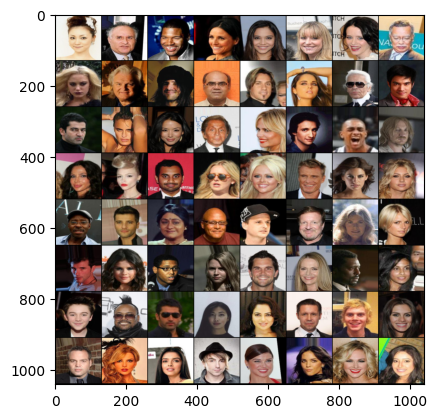

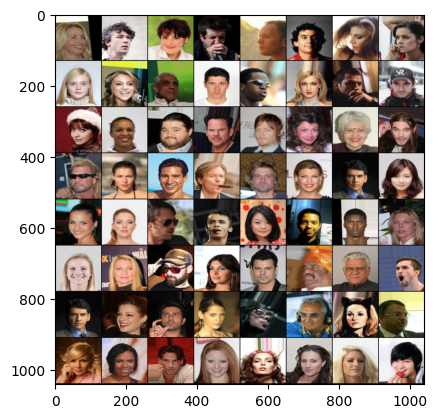

['The woman has high cheekbones and an oval face. She has arched eyebrows. She is smiling, is attractive and young. She is wearing earrings and lipstick.', 'The gentleman has a chubby face and has a double chin. He has gray and receding hair. He has a big nose and a slightly open mouth. The male is smiling. He is wearing a necktie.', 'The gentleman has a double chin and pretty high cheekbones. He has a goatee and has a mustache. His hair is black. He has big lips, a big nose, a slightly open mouth and narrow eyes. The gentleman is smiling. He is wearing a necktie.', 'The woman has pretty high cheekbones. Her hair is black. She has a slightly open mouth and a pointy nose. The woman seems attractive, young, is smiling and has heavy makeup. She is wearing lipstick.', 'The woman has pretty high cheekbones and an oval face. Her hair is black and straight. She has arched eyebrows, big lips, a slightly open mouth and narrow eyes. She is smiling, seems attractive, young and has heavy makeup. S

In [ ]:
images, labels, wrong_images = next(weighted_dataiter)
show_grid(torchvision.utils.make_grid(images, normalize=True))
show_grid(torchvision.utils.make_grid(wrong_images, normalize=True))
print(labels)

# Initialize Weights

In [ ]:
def initialize_weights(model):
    className = model.__class__.__name__
    if className.find('Conv') != -1:
        nn.init.normal_(model.weight.data, 0.0, 0.02)
    elif className.find('BatchNorm') != -1:
        nn.init.normal_(model.weight.data, 1.0, 0.02)
        nn.init.constant_(model.bias.data, 0)

# Generator Network

## Create Network

Hout = (Hin −1) × stride[0] − 2 × padding[0] + dilation[0] × (kernel_size[0] − 1) + output_padding[0] + 1

Wout = (Win −1) × stride[1] − 2 × padding[1] + dilation[1] × (kernel_size[1] − 1) + output_padding[1] + 1

In [ ]:
class Generator(nn.Module):
    '''
    The Generator Network
    '''

    def __init__(self, noise_size, feature_size, num_channels, embedding_size, reduced_dim_size):
        super(Generator, self).__init__()
        self.reduced_dim_size = reduced_dim_size

        self.projection = nn.Sequential(
            nn.Linear(in_features = embedding_size, out_features = reduced_dim_size),
            nn.BatchNorm1d(num_features = reduced_dim_size),
            nn.LeakyReLU(negative_slope = 0.2, inplace = True)
        )

        self.layer = nn.Sequential(
            nn.ConvTranspose2d(noise_size + reduced_dim_size, feature_size * 8, 4, 1, 0, bias = False),
            nn.BatchNorm2d(feature_size * 8),
            nn.LeakyReLU(negative_slope = 0.2, inplace = True),

            # state size (ngf*4) x 4 x 4
            nn.ConvTranspose2d(feature_size * 8, feature_size * 4, 4, 2, 1, bias = False),
            nn.BatchNorm2d(feature_size * 4),
            nn.ReLU(True),

            # state size. (ngf*4) x 8 x 8
            nn.ConvTranspose2d(feature_size * 4, feature_size * 2, 4, 2, 1, bias=False),
            nn.BatchNorm2d(feature_size * 2),
            nn.ReLU(True),

            # state size. (ngf*2) x 16 x 16
            nn.ConvTranspose2d(feature_size * 2, feature_size, 4, 2, 1, bias=False),
            nn.BatchNorm2d(feature_size),
            nn.ReLU(True),

            # state size. (ngf*2) x 32 x 32
            nn.ConvTranspose2d(feature_size, feature_size, 4, 2, 1, bias=False),
            nn.BatchNorm2d(feature_size),
            nn.ReLU(True),

            # state size. (ngf) x 64 x 64
            nn.ConvTranspose2d(feature_size, num_channels, 4, 2, 1, bias=False),
            nn.Tanh()

        )
        self.optimizer = torch.optim.Adam(self.parameters(), lr = 0.0002, betas = (0.5, 0.5))

    def forward(self, noise, text_embeddings):
        encoded_text = self.projection(text_embeddings)
        concat_input = torch.cat([noise, encoded_text], dim = 1).unsqueeze(2).unsqueeze(2)
        output = self.layer(concat_input)
        return output

In [ ]:
generator = Generator(cfg.noise_size, cfg.image_size, cfg.num_channels, 768, 256)
generator.apply(initialize_weights)
generator.cuda()

Generator(
  (projection): Sequential(
    (0): Linear(in_features=768, out_features=256, bias=True)
    (1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): LeakyReLU(negative_slope=0.2, inplace=True)
  )
  (layer): Sequential(
    (0): ConvTranspose2d(356, 1024, kernel_size=(4, 4), stride=(1, 1), bias=False)
    (1): BatchNorm2d(1024, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): LeakyReLU(negative_slope=0.2, inplace=True)
    (3): ConvTranspose2d(1024, 512, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (4): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU(inplace=True)
    (6): ConvTranspose2d(512, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (7): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (8): ReLU(inplace=True)
    (9): ConvTranspose2d(256, 128, kernel_size=(4, 4), stride=(2, 2),


## Test output shape of Generator

torch.Size([64, 3, 128, 128])


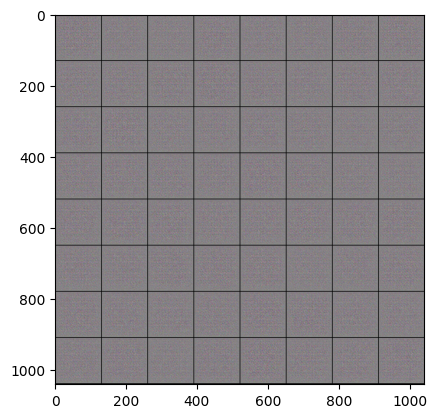

Generator(
  (projection): Sequential(
    (0): Linear(in_features=768, out_features=256, bias=True)
    (1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): LeakyReLU(negative_slope=0.2, inplace=True)
  )
  (layer): Sequential(
    (0): ConvTranspose2d(356, 1024, kernel_size=(4, 4), stride=(1, 1), bias=False)
    (1): BatchNorm2d(1024, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): LeakyReLU(negative_slope=0.2, inplace=True)
    (3): ConvTranspose2d(1024, 512, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (4): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU(inplace=True)
    (6): ConvTranspose2d(512, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (7): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (8): ReLU(inplace=True)
    (9): ConvTranspose2d(256, 128, kernel_size=(4, 4), stride=(2, 2),

In [ ]:
with torch.no_grad():
  generator.eval()
  noise = torch.randn(size=(cfg.batch_size, cfg.noise_size)).cuda()
  text_embeddings = sentence_encoder.convert_text_to_embeddings(labels)
  output = generator(noise, text_embeddings).detach()
  print(output.shape)
show_grid(torchvision.utils.make_grid(output.cpu(), normalize=True))
generator.train()

# Discriminator Network

## Create Network

Hout = ( (Hin + 2 × padding[0] − dilation[0] × (kernel_size[0] − 1) - 1) / stride[0]) + 1

Wout = ( (Win + 2 × padding[1] − dilation[1] × (kernel_size[1] − 1) - 1) / stride[1]) + 1


In [ ]:
class Discriminator(nn.Module):
    '''
    The Discriminator Network
    '''

    def __init__(self, num_channels, feature_size, embedding_size, reduced_dim_size):
        super(Discriminator, self).__init__()
        self.reduced_dim_size = reduced_dim_size

        ## Image Encoder
        self.netD_1 = nn.Sequential(
            # input nc x 128 x 128
            nn.Conv2d(num_channels, feature_size, 4, 2, 1, bias = False),
            nn.LeakyReLU(0.2, inplace = True),

            # input nc x 64 x 64
            nn.Conv2d(feature_size, feature_size, 4, 2, 1, bias = False),
            nn.LeakyReLU(0.2, inplace = True),

            # state size ndf x 32 x 32
            nn.Conv2d(feature_size, feature_size * 2, 4, 2, 1, bias = False),
            nn.BatchNorm2d(feature_size * 2),
            nn.LeakyReLU(0.2, inplace = True),

            # state size. (ndf*2) x 16 x 16
            nn.Conv2d(feature_size * 2, feature_size * 4, 4, 2, 1, bias=False),
            nn.BatchNorm2d(feature_size * 4),
            nn.LeakyReLU(0.2, inplace=True),

            # state size. (ndf*4) x 8 x 8
            nn.Conv2d(feature_size * 4, feature_size * 8, 4, 2, 1, bias=False),
            nn.BatchNorm2d(feature_size * 8),
            nn.LeakyReLU(0.2, inplace=True),

        )

        ## Text Encoder
        self.projector = nn.Sequential(
            nn.Linear(in_features=embedding_size, out_features=reduced_dim_size),
            nn.BatchNorm1d(num_features=reduced_dim_size),
            nn.LeakyReLU(negative_slope=0.2, inplace=True)
        )

        ## Text + Image Concat Layer
        self.netD_2 = nn.Sequential(
            # state size. (ndf*8) x 4 x 4
            nn.Conv2d(feature_size * 8 + reduced_dim_size, 1, 4, 1, 0, bias=False),
            nn.Sigmoid()
        )

        self.optimizer = torch.optim.Adam(self.parameters(), lr = 0.0001, betas = (0.5, 0.5))

    def forward(self, input_img, text_embeddings):
        x_intermediate = self.netD_1(input_img)

        projected_embed = self.projector(text_embeddings)

        replicated_embed = projected_embed.repeat(4, 4, 1, 1).permute(2,  3, 0, 1)
        hidden_concat = torch.cat([x_intermediate, replicated_embed], 1)

        x = self.netD_2(hidden_concat)

        return x.view(-1, 1), x_intermediate

In [ ]:
discriminator = Discriminator(cfg.num_channels, cfg.image_size, 768, 256)
discriminator.apply(initialize_weights)
discriminator.cuda()

Discriminator(
  (netD_1): Sequential(
    (0): Conv2d(3, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (1): LeakyReLU(negative_slope=0.2, inplace=True)
    (2): Conv2d(128, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (3): LeakyReLU(negative_slope=0.2, inplace=True)
    (4): Conv2d(128, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (5): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (6): LeakyReLU(negative_slope=0.2, inplace=True)
    (7): Conv2d(256, 512, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (8): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (9): LeakyReLU(negative_slope=0.2, inplace=True)
    (10): Conv2d(512, 1024, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (11): BatchNorm2d(1024, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (12): LeakyReLU(negative_slo

## Test output shape of Discriminator

In [ ]:
with torch.no_grad():
  discriminator.eval()
  validity, _ = discriminator(output, text_embeddings)
  print(validity.shape)
discriminator.train()

torch.Size([64, 1])


Discriminator(
  (netD_1): Sequential(
    (0): Conv2d(3, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (1): LeakyReLU(negative_slope=0.2, inplace=True)
    (2): Conv2d(128, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (3): LeakyReLU(negative_slope=0.2, inplace=True)
    (4): Conv2d(128, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (5): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (6): LeakyReLU(negative_slope=0.2, inplace=True)
    (7): Conv2d(256, 512, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (8): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (9): LeakyReLU(negative_slope=0.2, inplace=True)
    (10): Conv2d(512, 1024, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (11): BatchNorm2d(1024, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (12): LeakyReLU(negative_slo

# Specifying Loss Functions

In [ ]:
criterion = nn.BCELoss().cuda()
l2_loss = nn.MSELoss().cuda()
l1_loss = nn.L1Loss().cuda()

# Plotting output after each epoch

This is just to generate a batch of text embeddings to be used to plot

In [ ]:
plt_images, plt_labels, plt_wrong = next(weighted_dataiter)
plt_o_text_embeddings = sentence_encoder.convert_text_to_embeddings(plt_labels)
plt_o_text_embeddings.shape

torch.Size([64, 768])

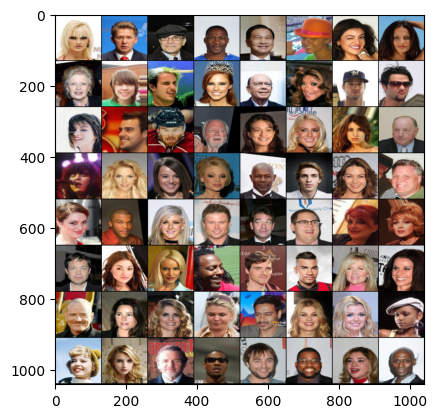

['Her hair is blond and straight. She has a slightly open mouth. The female seems young and has heavy makeup. She is wearing lipstick.', 'He has brown and straight hair. He has a big nose and a slightly open mouth. He is wearing a necktie.', 'The male is chubby and has a double chin. He has a big nose. He is wearing eyeglasses, a hat and a necktie.', 'The man has a chubby face, has pretty high cheekbones and an oval face. He wears a goatee and has a mustache. He has black and receding hair. He has big lips, a big nose and a slightly open mouth. He is smiling and looks young. He is wearing earrings.', 'The man has a chubby face and has pretty high cheekbones. His hair is black. He has a big nose, a slightly open mouth and narrow eyes. The male is smiling. He is wearing a necktie.', 'The female has pretty high cheekbones. She has a slightly open mouth and a pointy nose. She is smiling and looks young. She is wearing a hat.', 'The lady has high cheekbones. She has wavy hair. She has bushy

In [ ]:
show_grid(torchvision.utils.make_grid(plt_images.cpu(), normalize=True))
print(plt_labels)

In [ ]:
fixed_noise = torch.randn(size=(len(plt_labels), cfg.noise_size)).cuda()

In [ ]:
def plot_output(epoch):
  plt.clf()
  with torch.no_grad():

    generator.eval()
    test_images = generator(fixed_noise, plt_o_text_embeddings)
    generator.train()

    grid = torchvision.utils.make_grid(test_images.cpu(), normalize=True)
    show_grid(grid)


# Training

In [ ]:
pbar = tqdm()

for epoch in range(cfg.epochs):
    print(f'Epoch:  {epoch + 1} / {cfg.epochs}')
    pbar.reset(total = len(weighted_dataloader))

    discriminator_loss = []
    generator_loss = []

    for i, (real_images, real_text, wrong_images) in enumerate(weighted_dataloader):
        current_batch_size = real_images.size()[0]

        #converting to cuda
        real_images = real_images.cuda()
        text_embeddings = sentence_encoder.convert_text_to_embeddings(real_text)
        wrong_images = wrong_images.cuda()

        real_validity = torch.ones(current_batch_size, 1).cuda()
        fake_validity = torch.zeros(current_batch_size, 1).cuda()

        temp_tensor = (torch.ones(current_batch_size, 1).cuda()) * (-0.1)
        smoothed_real_labels = torch.add(real_validity, temp_tensor)

        ## Training the discriminator
        discriminator.zero_grad()
        output, activation_real = discriminator(real_images, text_embeddings)
        real_loss = criterion(output, smoothed_real_labels)
        real_score = output

        output, _ = discriminator(wrong_images, text_embeddings)
        wrong_loss = criterion(output, fake_validity)

        input_noise = torch.randn(size=(current_batch_size, cfg.noise_size)).cuda()
        fake_images = generator(input_noise, text_embeddings)
        output, _ = discriminator(fake_images, text_embeddings)
        fake_loss = criterion(output, fake_validity)

        d_loss = real_loss + wrong_loss + fake_loss

        d_loss.backward()
        discriminator.optimizer.step()
        discriminator_loss.append(d_loss)

        ## Training generator
        generator.zero_grad()
        input_noise = torch.randn(size=(current_batch_size, cfg.noise_size)).cuda()
        fake_images = generator(input_noise, text_embeddings)
        output, activation_fake = discriminator(fake_images, text_embeddings)
        _, activation_real = discriminator(real_images, text_embeddings)

        activation_fake = torch.mean(activation_fake, 0)    #try with median and check if it converges
        activation_real = torch.mean(activation_real, 0)    #try with median and check if it converges

        g_loss = criterion(output, real_validity) + 100 * l2_loss(activation_fake, activation_real.detach()) + 50 * l1_loss(fake_images, real_images)

        g_loss.backward()
        generator.optimizer.step()
        generator_loss.append(g_loss)

        pbar.update()

    print('Discriminator Loss: {:.3f}, Generator Loss: {:.3f}'.format(
          torch.mean(torch.FloatTensor(discriminator_loss)),
          torch.mean(torch.FloatTensor(generator_loss))

  ))

    if (epoch + 1) % 1 == 0:
      plot_output(epoch + 1)

pbar.refresh()

# Output

In [ ]:
test_noise = torch.randn(size=(1, cfg.noise_size)).cuda()
test_embeddings = sentence_encoder.convert_text_to_embeddings(['The man is chubby, has a double chin and pretty high cheekbones. He grows a sideburns. His hair is gray and receding. He has big lips and a big nose. The man looks young.'])